# Climate Change Perception

### Import Libraries

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
from sklearn import linear_model
from sklearn.metrics import r2_score

### Data Import and Processing

In [41]:
perception = pd.read_csv('../2024/Cleaned Data/CC Perception.csv')
disasters = pd.read_csv('../2024/Cleaned Data/Disaster Deaths.csv')
education = pd.read_csv('../2024/Cleaned Data/Education.csv')
oil = pd.read_csv('../2024/Cleaned Data/Oil Production.csv')
media = pd.read_csv('../2024/Cleaned Data/Press Freedom.csv')

In [42]:
perception = perception.drop(columns=['Year'])
perception = perception.rename(columns={'Overall is threat': 'Overall threat perception'})
perception['Very serious threat'] = perception['Very serious threat'].str.rstrip('%').astype('float')
perception['Somewhat serious threat '] = perception['Somewhat serious threat '].str.rstrip('%').astype('float')
perception['Overall threat perception'] = perception['Overall threat perception'].str.rstrip('%').astype('float')


In [43]:
disasters = disasters[disasters['Year'] >= 2011]
disasters = disasters.drop(columns=['name','Year','Number of natural disaster deaths'])
disasters = disasters.groupby('geo').agg('sum')

In [44]:
education = education.drop(columns=['Country'])
education = education.rename(columns={'Country code': 'geo'})
education['geo']=education['geo'].str.lower()

In [45]:
oil = oil.drop(columns=['country'])
oil = oil.rename(columns={'code': 'geo', '2019 production': 'Oil Production'})
oil['geo']= oil['geo'].str.lower()

In [46]:
media = media.rename(columns={'Code': 'geo', 'Score': 'Press Freedom'})
media['geo']= media['geo'].str.lower()

### Merge and process data

In [86]:
df = pd.merge(perception,disasters,on='geo',how='outer')
df = pd.merge(df,education,on='geo',how='outer')
df = pd.merge(df,oil,on='geo',how='outer')
df = pd.merge(df,media,on='geo',how='outer')


df = df.dropna(subset=['Overall threat perception'])
df['Disaster Deaths per 100K People'] = df['Number of natural disaster deaths, excluding epidemics '] / df['Population'] * 100000
df = df.drop(columns=['Number of natural disaster deaths, excluding epidemics '])
df['Oil Production'] = df['Oil Production'].fillna(0)
df['MYS'] = df['MYS'].fillna(df['MYS'].median())
df['Disaster Deaths per 100K People'] = df['Disaster Deaths per 100K People'].fillna(df['Disaster Deaths per 100K People'].median())

### Exploratory Data Analysis

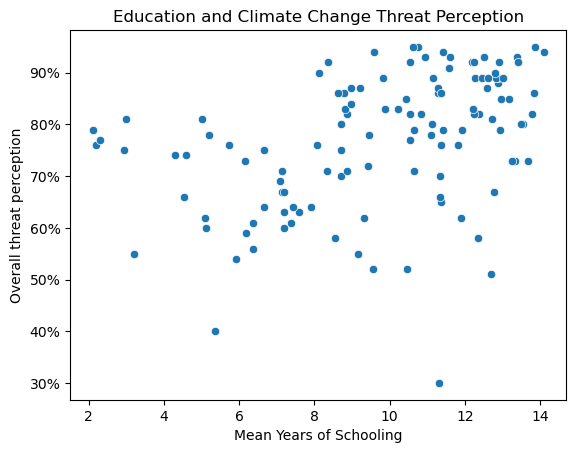

In [62]:
plot = sns.scatterplot(x='MYS', y='Overall threat perception', data=df)
plt.xlabel('Mean Years of Schooling')
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Education and Climate Change Threat Perception", loc='center', size=12);

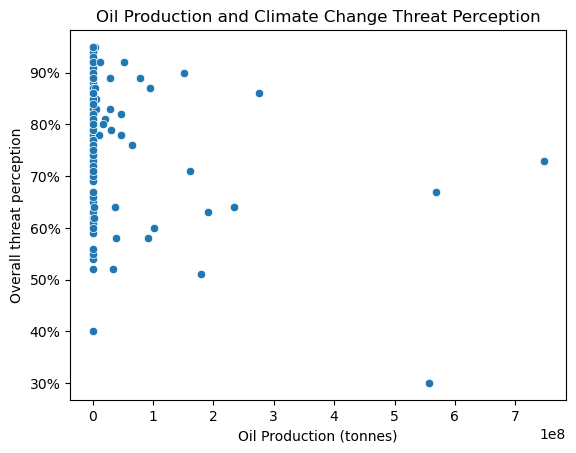

In [65]:
plot = sns.scatterplot(x='Oil Production', y='Overall threat perception', data=df)
plt.xlabel('Oil Production (tonnes)')
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Oil Production and Climate Change Threat Perception", loc='center', size=12);

c:\Users\SarahEshafi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


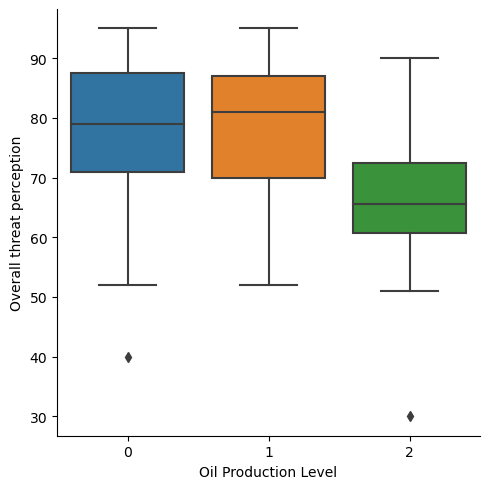

In [89]:
df['Oil Production Level'] = df['Oil Production'].apply(lambda x: 0 if x == 0 else 1 if x < 100000000 else 2)
plot = sns.catplot(data=df, x="Oil Production Level", y="Overall threat perception", kind="box");

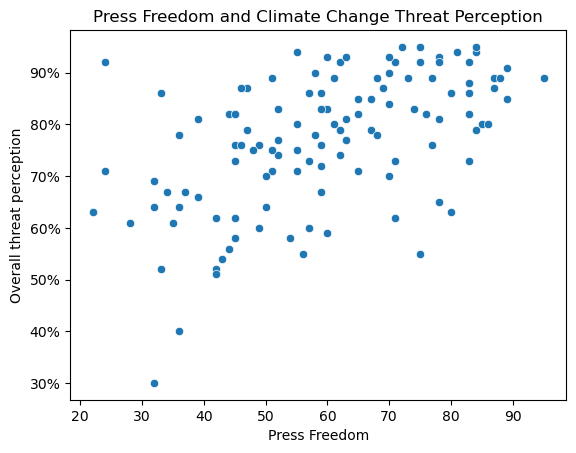

In [66]:
plot = sns.scatterplot(x='Press Freedom', y='Overall threat perception', data=df)
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Press Freedom and Climate Change Threat Perception", loc='center', size=12);

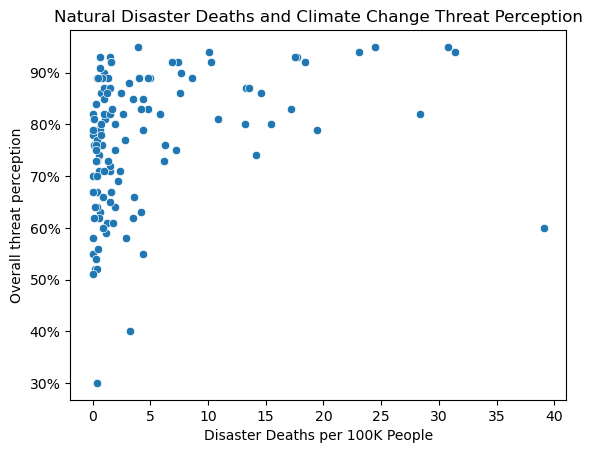

In [143]:
plot = sns.scatterplot(x=df['Disaster Deaths per 100K People'], y='Overall threat perception', data=df)
plot.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Natural Disaster Deaths and Climate Change Threat Perception", loc='center', size=12);

In [147]:
df['log_disaster deaths'] = np.log10(df['Disaster Deaths per 100K People'])
df['log_disaster deaths'] = df['Disaster Deaths per 100K People'].apply(lambda x: -1 if x < 0.1 else np.log10(x))

c:\Users\SarahEshafi\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


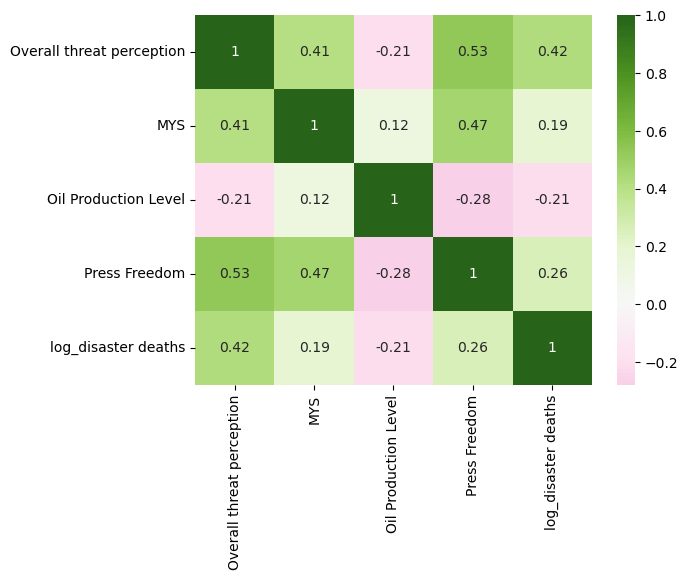

In [148]:
df_trimmed = df[['Overall threat perception', 'MYS', 'Oil Production Level', 'Press Freedom', 'log_disaster deaths']]
corr_matrix = df_trimmed.corr()
sns.heatmap(corr_matrix, annot=True, center=0, cmap="PiYG")
plt.show()

### Build the regression model

In [149]:
Y = df['Overall threat perception']
X = df[['MYS', 'Oil Production Level', 'Press Freedom', 'log_disaster deaths']]
reg = linear_model.LinearRegression()
reg.fit(X, Y);

In [150]:
reg.coef_

array([ 0.88569391, -1.61328471,  0.25337744,  5.21784664])

### Evaluate the model

In [151]:
y_pred = reg.predict(X)
r2_score(Y, y_pred)

0.39956623368661237

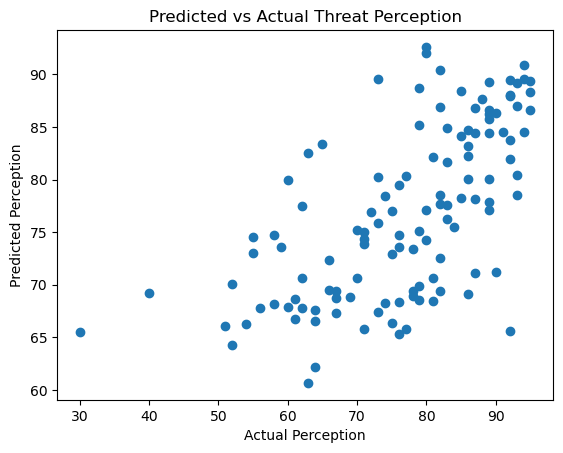

In [152]:
plot = plt.scatter(Y, y_pred)
plt.xlabel('Actual Perception')
plt.ylabel('Predicted Perception')
plt.title("Predicted vs Actual Threat Perception", loc='center', size=12);